# Evaluation
## Motivating example
A telecom company wants to anticipate a current customer's decision to end their contract and turn to a competitor's services. This would allow for proactivate measures such as targeted ads and promotions to increase the probability that that customer is retained.

This is an example of a binary classification problem, whereby each data point is assigned one of two possible discrete classes. In our case, the customer base is split base on whether or not they are predicted to churn in the near future.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from collections import Counter

## Data Preparation

In [27]:
df = pd.read_csv('data.csv')

In [28]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [29]:
# standardize column names
df.columns = map(lambda x: x.lower().replace(" ", "_"), df.columns)

In [30]:
str_cols = df.dtypes[df.dtypes == 'object'].index

for col in str_cols:
	df[col] = df[col].str.lower().str.replace(" ", "_")

In [31]:
# convert and impute total charges
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce').fillna(0)

In [32]:
df.seniorcitizen = df.seniorcitizen.map({0: 'no', 1: 'yes'})

In [33]:
df.churn = (df.churn == 'yes').astype(int)

In [34]:
df.drop('customerid', axis=1, inplace=True)

## Validation Framework

In [35]:
def data_split(df, test_size, val_size, random_state=42):
	df, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
	df_train, df_val = train_test_split(df, test_size=val_size/(1-test_size), random_state=random_state)

	return df_train, df_val, df_test

In [36]:
df_train, df_val, df_test = data_split(df, test_size=.2, val_size=.2, random_state=1)

In [37]:
assert df_val.shape == df_test.shape

In [38]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [39]:
# split input and target features
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

df_train.drop('churn', axis=1, inplace=True)
df_val.drop('churn', axis=1, inplace=True)
df_test.drop('churn', axis=1, inplace=True)

## Feature Encoding

In [40]:
def one_hot_encoding(df, enc=None):
	# separate numerical and categorical features
	df_numerical = df.select_dtypes('number')
	df_categorical = df.select_dtypes(exclude='number')

	# fit a new encoder on the categorical data
	if not enc:
		enc = OneHotEncoder(dtype=np.int64, sparse_output=False)
		enc.fit(df_categorical)

	X = pd.DataFrame(
		data=enc.transform(df_categorical),
		columns=enc.get_feature_names_out())

	# combine encodings and numerical features
	df_encoded = pd.concat([df_numerical, X], axis=1)

	return df_encoded, enc

In [41]:
X_train, enc = one_hot_encoding(df_train)
X_val, _ = one_hot_encoding(df_val, enc)
X_test, _ = one_hot_encoding(df_test, enc)

## Model Training

In [42]:
model = LogisticRegression(max_iter=100000)
model.fit(X_train.values, y_train)

LogisticRegression(max_iter=100000)

In [43]:
y_pred = model.predict_proba(X_val.values)[:, 1]
churn_decision = (y_pred >= .5)
(y_val == churn_decision).mean()

0.8034066713981547

## Evaluation
### Accuracy and dummy model
Accuracy measures the percentage of correct predictions made by the model.

In [46]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
	score = accuracy_score(y_val, y_pred >= t)
	scores.append(score)

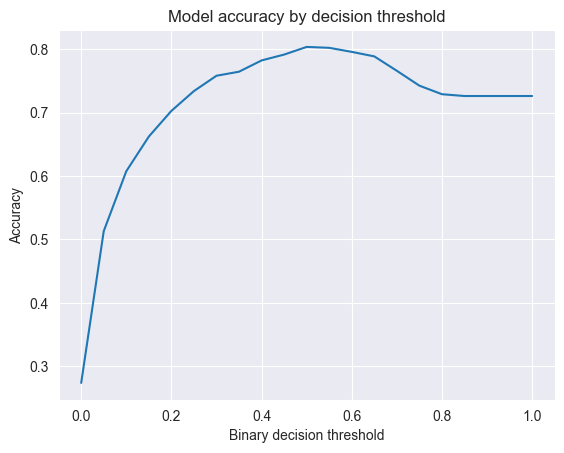

In [47]:
plt.plot(thresholds, scores)
plt.title('Model accuracy by decision threshold')
plt.xlabel('Binary decision threshold')
plt.ylabel('Accuracy')
plt.show()

In [51]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

The model achieves an accuracy higher than 70% when the decision threshold is 1.0, i.e when the model never predicts a positive case. This is a symptom of class imbalance in the data and reveals a flaw in the accuracy metric.

### Confusion matrix